# Cosmology with one galaxy using mixture density networks

The goal of this notebook is to reproduce the results of the paper "Cosmology with 1 galaxy". We are going to use the CAMELS simulation suite to estimate the matter density of the universe ($\Omega_{M}$) uisng observable properties of galaxies.

Before starting the notebook, you can read about the CAMELS simualtion.

In [149]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers as tfkl
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import seaborn as sns
import cosmo_1_galaxy

# Check for TensorFlow GPU access
print(
    f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}"
)

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

tf.config.experimental.set_visible_devices([], "GPU")

# Check for TensorFlow GPU access
print(
    f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}"
)

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.13.0
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [274]:
tng_data = "cosmo_1_galaxy:1.0.0"
simba_data = "cosmo_1_galaxy:1.0.1"

data_dir = "/home/jovyan/tensorflow_datasets"

dset_train = tfds.load(tng_data, split="train", data_dir=data_dir)
dset_test = tfds.load(tng_data, split="test", data_dir=data_dir)
dset_valid = tfds.load(tng_data, split="valid", data_dir=data_dir)

This is just a list of the observable properties 

[0,1,2,6,7,8,9,10,11,14,15,16]

gal_prop[count:count+Ngal,0]  = Mg[indexes]
gal_prop[count:count+Ngal,1]  = Mstar[indexes]
gal_prop[count:count+Ngal,2]  = Mbh[indexes]
gal_prop[count:count+Ngal,3]  = Mtot[indexes]
gal_prop[count:count+Ngal,4]  = Vmax[indexes]
gal_prop[count:count+Ngal,5]  = Vdisp[indexes]
gal_prop[count:count+Ngal,6]  = Zg[indexes]
gal_prop[count:count+Ngal,7]  = Zs[indexes]
gal_prop[count:count+Ngal,8]  = SFR[indexes]
gal_prop[count:count+Ngal,9]  = J[indexes]
gal_prop[count:count+Ngal,10] = V[indexes]
gal_prop[count:count+Ngal,11] = Rstar[indexes]
gal_prop[count:count+Ngal,12] = Rtot[indexes]
gal_prop[count:count+Ngal,13] = Rvmax[indexes]
gal_prop[count:count+Ngal,14] = U[indexes]
gal_prop[count:count+Ngal,15] = K[indexes]
gal_prop[count:count+Ngal,16] = g[indexes]



Let's plot some galaxy properties against cosmological parameters

2023-08-22 09:15:50.122009: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-08-22 09:15:50.166994: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-08-22 09:15:50.200720: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

<Figure size 800x600 with 0 Axes>

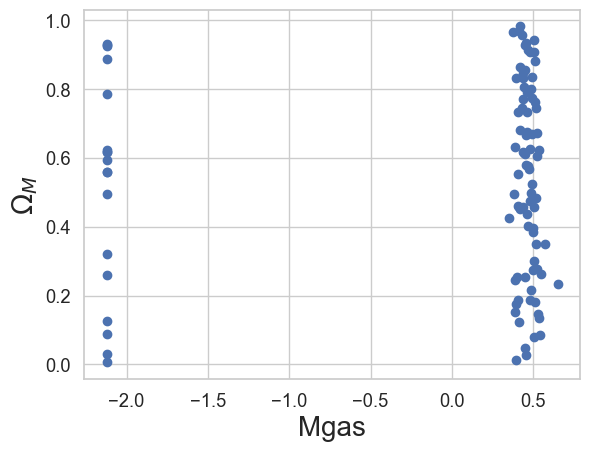

<Figure size 800x600 with 0 Axes>

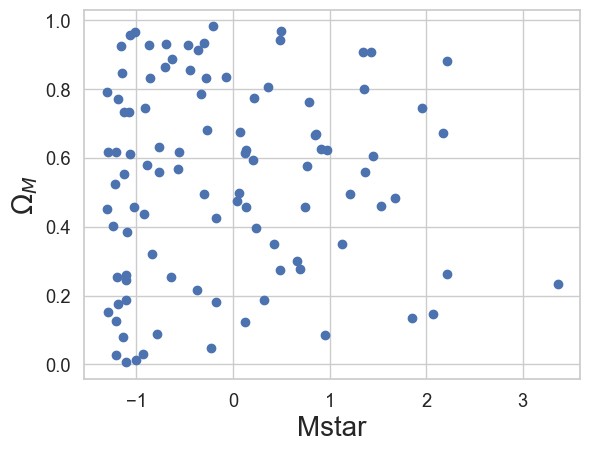

<Figure size 800x600 with 0 Axes>

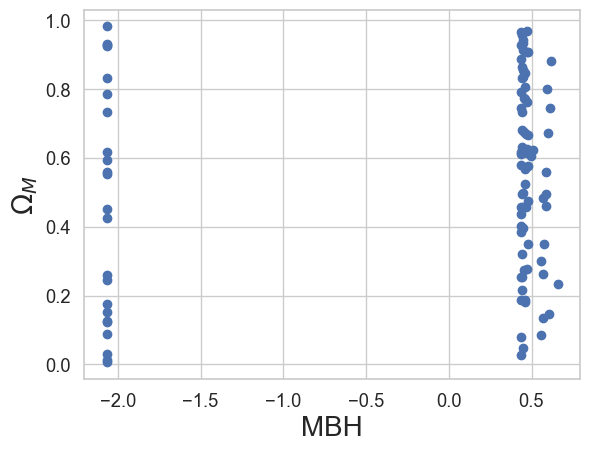

<Figure size 800x600 with 0 Axes>

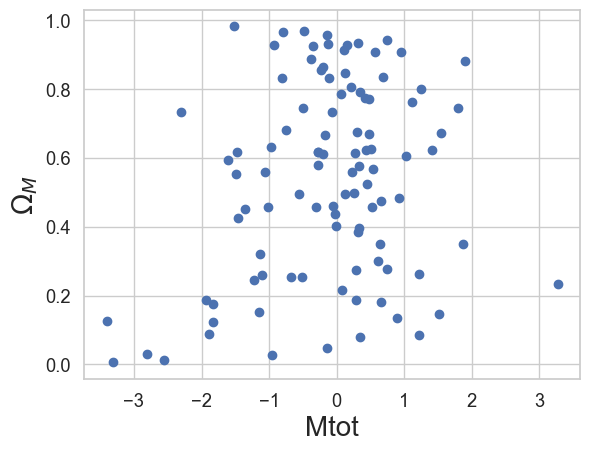

<Figure size 800x600 with 0 Axes>

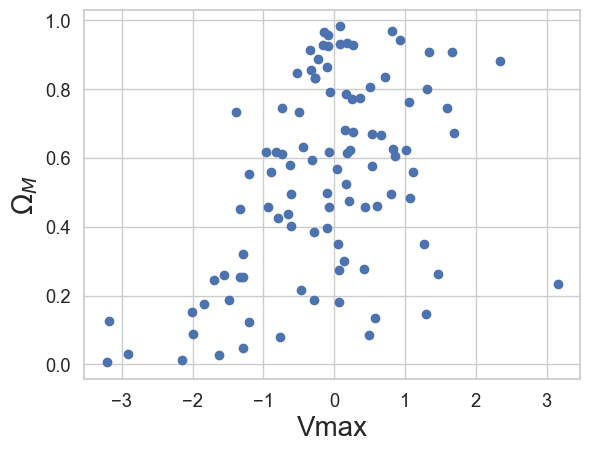

<Figure size 800x600 with 0 Axes>

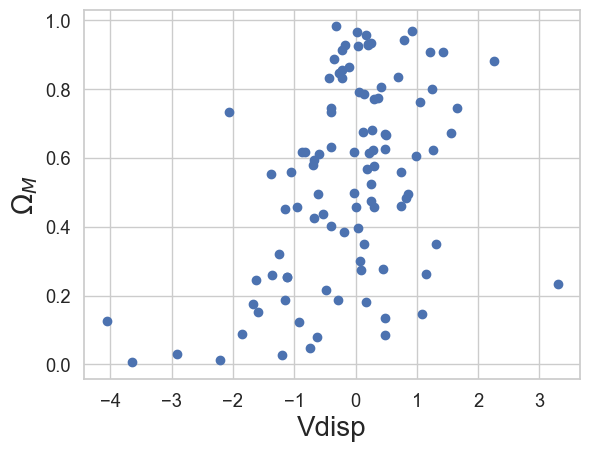

<Figure size 800x600 with 0 Axes>

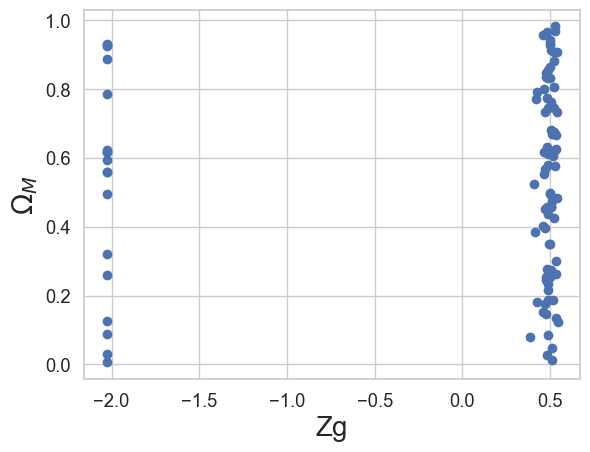

<Figure size 800x600 with 0 Axes>

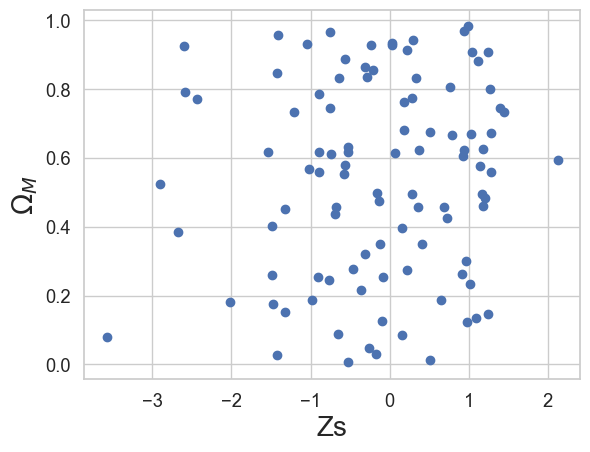

<Figure size 800x600 with 0 Axes>

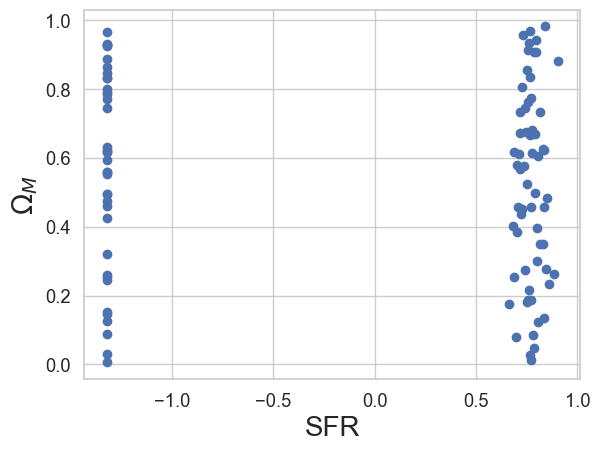

<Figure size 800x600 with 0 Axes>

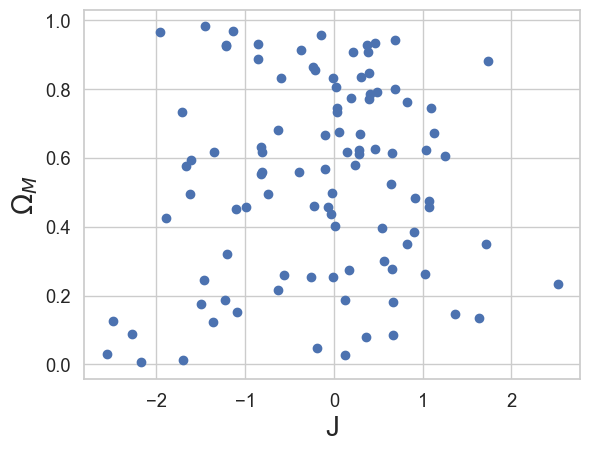

<Figure size 800x600 with 0 Axes>

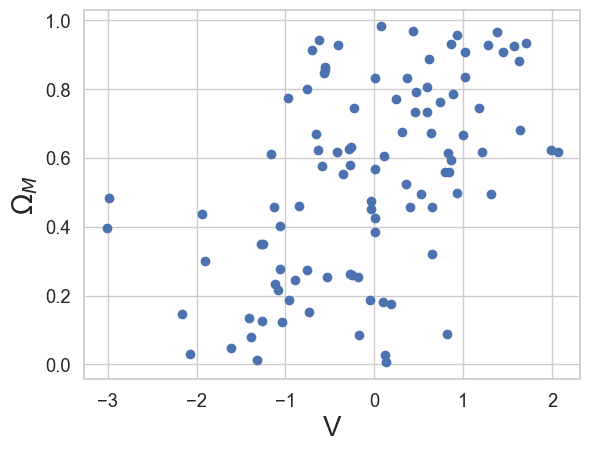

<Figure size 800x600 with 0 Axes>

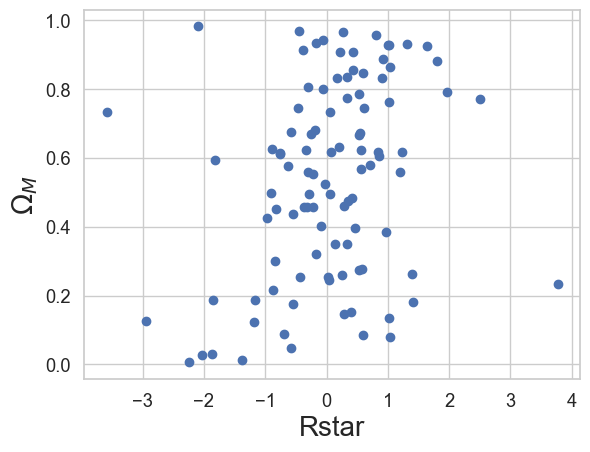

<Figure size 800x600 with 0 Axes>

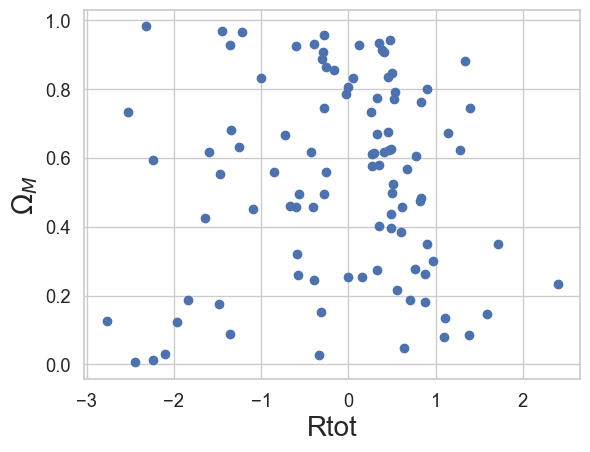

<Figure size 800x600 with 0 Axes>

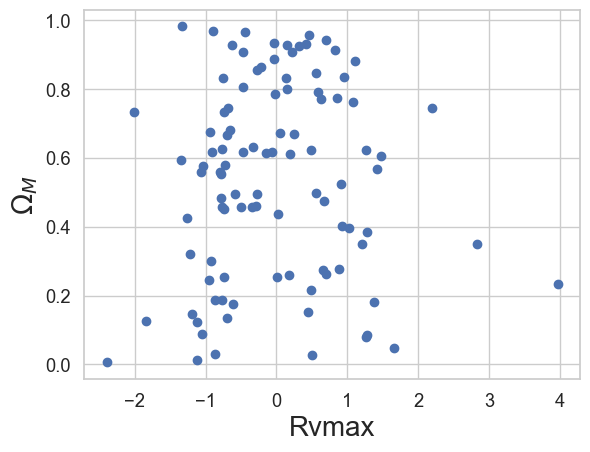

<Figure size 800x600 with 0 Axes>

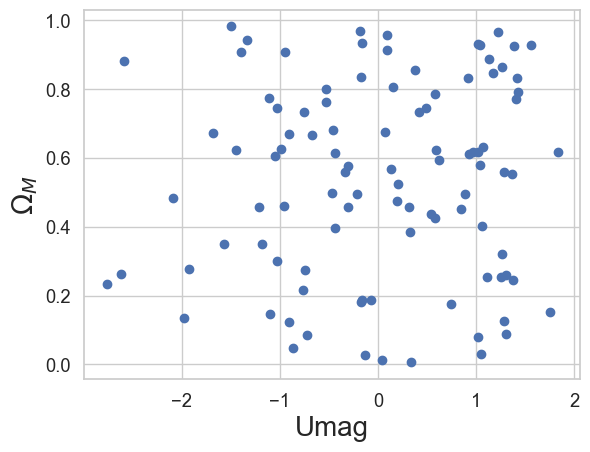

<Figure size 800x600 with 0 Axes>

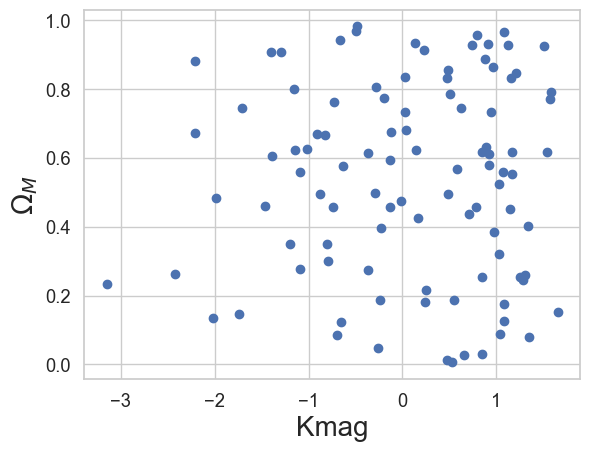

<Figure size 800x600 with 0 Axes>

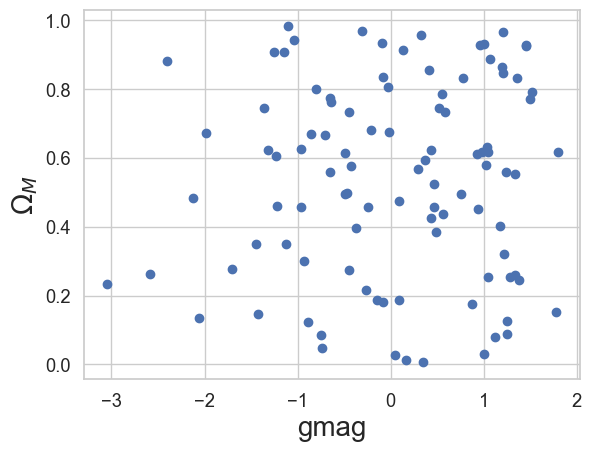

In [275]:
galprop = [
    "Mgas",
    "Mstar",
    "MBH",
    "Mtot",
    "Vmax",
    "Vdisp",
    "Zg",
    "Zs",
    "SFR",
    "J",
    "V",
    "Rstar",
    "Rtot",
    "Rvmax",
    "Umag",
    "Kmag",
    "gmag",
]
cosmo = [
    "$\Omega_M$",
    "$\sigma_8$",
    "$A_{SN1}$",
    "$A_{SN2}$",
    "$A_{AGN1}$",
    "$A_{AGN2}$",
]
# ,"Rstar","Rtot","Rvmax","Umag","Kmag","gmag"]

cosmo_ind = 0  # this contains omega matter

examples = dset_train.take(100).cache()

for galprop_ind, lbl in zip(range(len(galprop)), galprop):
    galpropvec = []

    cosmovec = []
    for example in examples:
        galpropvec.append(example["input"][galprop_ind].numpy())
        cosmovec.append(example["output"][cosmo_ind].numpy())
    # print(example['output'][0])
    # Create a line plot using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure()
    plt.scatter(galpropvec, cosmovec)
    plt.xlabel(lbl, fontsize=20)
    plt.ylabel(cosmo[cosmo_ind], fontsize=20)

# Part 1: Simple MLP

Model definition. Simple MLP. We use a standard mean square error loss.

In [264]:
def optuna_best_model():
    """Creates a small fully connected network"""
    return tf.keras.Sequential(
        [
            tfkl.Input(shape=(14)),
            tfkl.Dense(1022, activation="LeakyReLU"),
            tfkl.Dropout(0.5277883627689858),
            tfkl.Dense(975, activation="LeakyReLU"),
            tfkl.Dropout(0.20184706977545483),
            tfkl.Dense(1311, activation="LeakyReLU"),
            tfkl.Dropout(0.5022290156424203),
            tfkl.Dense(1),
        ]
    )


mlp = Model()
mlp.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss=tf.keras.losses.MSE)

In [ ]:
def simple_model():
    """Creates a small fully connected network"""
    return tf.keras.Sequential(
        [
            tfkl.Input(shape=(14)),
            tfkl.Dense(16, activation="relu"),
            tfkl.Dense(32, activation="relu"),
            tfkl.Dense(64, activation="relu"),
            tfkl.Dense(128, activation="relu"),
            tfkl.Dense(1),
        ]
    )


def best_model():
    """Creates a small fully connected network"""
    model = tf.keras.Sequential(
        [
            tfkl.Input(shape=(14)),
            tfkl.Dense(1024, activation="LeakyReLU"),
            tfkl.Dropout(0.5),
            tfkl.Dense(1024, activation="LeakyReLU"),
            tfkl.Dropout(0.2),
            tfkl.Dense(1024, activation="LeakyReLU"),
            tfkl.Dropout(0.5),
            tfkl.Dense(1),
        ]
    )
    return model


mlp = best_model()
mlp.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss=tf.keras.losses.MSE)

Main function for preparing datasets

In [265]:
# [0,1,2,6,7,8,9,10,11,14,15,16]


def preprocessing(x, y, features):
    galprop = x
    cosmo = y[:, 0:1]
    return galprop, cosmo


def input_fn(
    mode="train", batch_size=64, features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
):
    """
    mode: 'train', test' or 'val'
    """
    keys = ["input", "output"]
    if mode == "train":
        dataset = tfds.load(tng_data, split="train", data_dir=data_dir)
        dataset = dataset.map(
            lambda x: (tf.gather(x["input"], features, axis=0), x["output"], features)
        )
        # filter_no_nan = lambda x,y: (tf.reduce_all(~tf.math.is_nan(x)))
        # dataset = dataset.filter(filter_no_nan)
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
        dataset = dataset.batch(batch_size, drop_remainder=True)
    if mode == "val":
        dataset = tfds.load(tng_data, split="valid", data_dir=data_dir)
        dataset = dataset.map(
            lambda x: (tf.gather(x["input"], features, axis=0), x["output"], features)
        )
        dataset = dataset.batch(batch_size, drop_remainder=True)
    if mode == "test":
        dataset = tfds.load(tng_data, split="test", data_dir=data_dir)
        dataset = dataset.map(
            lambda x: (tf.gather(x["input"], features, axis=0), x["output"], features)
        )
        dataset = dataset.batch(batch_size, drop_remainder=False)

    dataset = dataset.map(preprocessing)  # Apply data preprocessing
    dataset = dataset.prefetch(
        -1
    )  # fetch next batches while training current one (-1 for autotune)
    return dataset

Training the network

In [266]:
dset_train = input_fn()
dset_val = input_fn(mode="val")
history = mlp.fit(dset_train, validation_data=dset_val, epochs=5, steps_per_epoch=1000)

Epoch 1/20
1000/1000 [==============================] - 14s 14ms/step - loss: 0.0320 - val_loss: 0.0142
Epoch 2/20
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0182 - val_loss: 0.0140
Epoch 3/20
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0185 - val_loss: 0.0135
Epoch 4/20
1000/1000 [==============================] - 13s 13ms/step - loss: 0.0172 - val_loss: 0.0119
Epoch 5/20
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0174 - val_loss: 0.0160
Epoch 6/20
1000/1000 [==============================] - 13s 13ms/step - loss: 0.0190 - val_loss: 0.0138
Epoch 7/20
1000/1000 [==============================] - 13s 13ms/step - loss: 0.0317 - val_loss: 0.0119
Epoch 8/20
1000/1000 [==============================] - 13s 13ms/step - loss: 0.0168 - val_loss: 0.0125
Epoch 9/20
1000/1000 [==============================] - 13s 13ms/step - loss: 0.0166 - val_loss: 0.0124
Epoch 10/20
1000/1000 [==============================] - 13s 13m

Plot the results for the test set

858/858 [==============================] - 10s 11ms/step


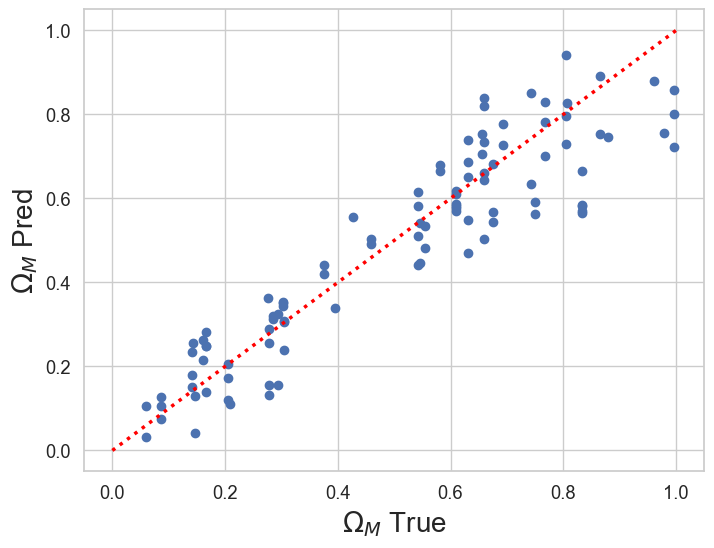

In [267]:
dset_test = input_fn(mode="test")
omega_pred = mlp.predict(dset_test)


omega_test = []
dset_test = tfds.load(tng_data, split="test", data_dir=data_dir)
for example in dset_test.take(-1):
    omega_test.append(example["output"][0].numpy())


# Create a line plot using Seaborn
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(8, 6))
plt.scatter(omega_test[0:100], omega_pred[0:100])
plt.xlabel("$\Omega_M$ True", fontsize=20)
plt.ylabel("$\Omega_M$ Pred", fontsize=20)

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="red", ls=":")

# Part 2: Mixture Density Network

Model definition. We replace the last layer with a probabilistic layer

In [268]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfkl = tf.keras.layers

num_components = 1
event_shape = [1]

params_size = tfp.layers.MixtureSameFamily.params_size(
    num_components,
    component_params_size=tfp.layers.IndependentNormal.params_size(event_shape),
)

mdn = tf.keras.Sequential(
    [
        tfkl.Input(shape=(14)),
        tfkl.Dense(1024, activation="LeakyReLU"),
        tfkl.Dropout(0.5),
        tfkl.Dense(1024, activation="LeakyReLU"),
        tfkl.Dropout(0.2),
        tfkl.Dense(1024, activation="LeakyReLU"),
        tfkl.Dropout(0.5),
        tfkl.Dense(units=params_size, activation=None),
        tfp.layers.MixtureSameFamily(
            num_components, tfp.layers.IndependentNormal(event_shape)
        ),
    ]
)

optuna_mdn = tf.keras.Sequential(
    [
        tfkl.Input(shape=(14)),
        tfkl.Dense(1022, activation="LeakyReLU"),
        tfkl.Dropout(0.5277883627689858),
        tfkl.Dense(975, activation="LeakyReLU"),
        tfkl.Dropout(0.20184706977545483),
        tfkl.Dense(1311, activation="LeakyReLU"),
        tfkl.Dropout(0.5022290156424203),
        tfkl.Dense(units=params_size, activation=None),
        tfp.layers.MixtureSameFamily(
            num_components, tfp.layers.IndependentNormal(event_shape)
        ),
    ]
)

negloglik = lambda y, p_y: -p_y.log_prob(y)


opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002)
mdn.compile(loss=negloglik, optimizer=opt)

In [269]:
dset_train = input_fn()
dset_val = input_fn(mode="val")
history = mdn.fit(dset_train, validation_data=dset_val, epochs=5, steps_per_epoch=3000)

Epoch 1/20
3000/3000 [==============================] - 33s 11ms/step - loss: -0.3574 - val_loss: -0.6891
Epoch 2/20
3000/3000 [==============================] - 29s 10ms/step - loss: -0.6911 - val_loss: -0.8668
Epoch 3/20
3000/3000 [==============================] - 30s 10ms/step - loss: -0.7550 - val_loss: -0.8872
Epoch 4/20
3000/3000 [==============================] - 30s 10ms/step - loss: -0.7833 - val_loss: -0.8855
Epoch 5/20
3000/3000 [==============================] - 29s 10ms/step - loss: -0.8020 - val_loss: -0.8917
Epoch 6/20
3000/3000 [==============================] - 26s 9ms/step - loss: -0.8203 - val_loss: -0.9300
Epoch 7/20
3000/3000 [==============================] - 25s 8ms/step - loss: -0.8290 - val_loss: -0.8922
Epoch 8/20
3000/3000 [==============================] - 25s 8ms/step - loss: -0.8351 - val_loss: -0.9341
Epoch 9/20
3000/3000 [==============================] - 25s 8ms/step - loss: -0.8378 - val_loss: -0.8695
Epoch 10/20
3000/3000 [===========================

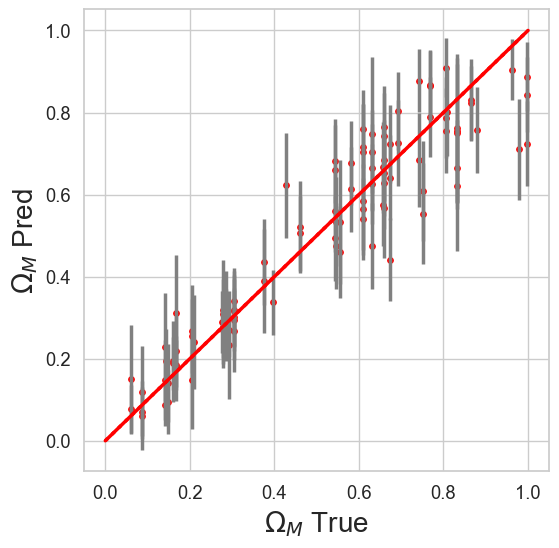

In [270]:
dset_test = input_fn(mode="test")
omega_pred_mean = np.concatenate([mdn(batch[0]).mean() for batch in dset_test])
omega_pred_std = np.concatenate([mdn(batch[0]).stddev() for batch in dset_test])

omega_test = []
dset_test = tfds.load("cosmo_1_galaxy", split="test", data_dir=data_dir)
for example in dset_test.take(-1):
    omega_test.append(example["output"][0].numpy())


# Create a line plot using Seaborn
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(6, 6))
plt.errorbar(
    np.squeeze(omega_test[0:100]),
    np.squeeze(omega_pred_mean[0:100]),
    yerr=np.squeeze(omega_pred_std[0:100]),
    color="gray",
    fmt="none",
)
plt.scatter(omega_test[0:100], omega_pred_mean[0:100], color="red", s=15)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="red")
plt.xlabel("$\Omega_M$ True", fontsize=20)
plt.ylabel("$\Omega_M$ Pred", fontsize=20)

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="red", ls=":")

We now plot some posterior distributions (assumed to be Gaussian)

2023-08-22 09:07:28.605667: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<Figure size 400x400 with 0 Axes>

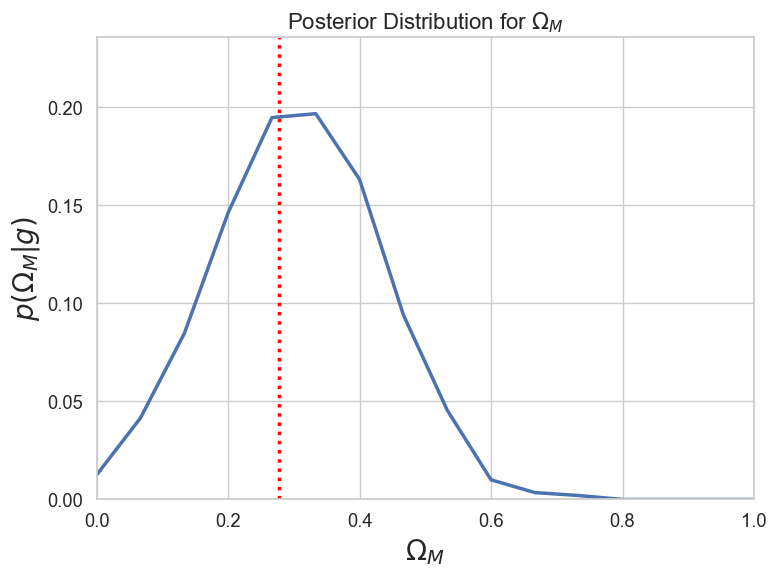

In [271]:
dset_test = input_fn(mode="test")
iterator = iter(dset_test)


nplots = 1
for b in range(nplots):
    batch = iterator.get_next()
    nsamples = 2000
    omega_pred_samples = []
    for i in range(nsamples):
        omega_pred_samples.append((mdn(batch[0]).sample())[b])

    # Create a normalized histogram using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(4, 4))

    # Compute the PDF using a normalized histogram
    hist, bin_edges = np.histogram(
        np.squeeze(np.array(omega_pred_samples)),
        bins=30,
        density=True,
        range=(-0.5, 1.5),
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    pdf = hist * np.diff(bin_edges)

    # Create a line plot using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))
    # Plot the PDF as a line plot
    sns.lineplot(x=bin_centers, y=pdf, color="b")
    plt.xlabel(r"$\Omega_M$", fontsize=20)
    plt.ylabel(r"$p(\Omega_M|g)$", fontsize=20)
    plt.title("Posterior Distribution for $\Omega_M$", fontsize=16)
    plt.xlim(0, 1)
    plt.ylim(0, max(pdf) * 1.2)  # Adjust y-axis limits as needed

    plt.axvline(x=batch[1][b], color="red", ls=":")

    # Save or show the plot
    # plt.tight_layout()
    # plt.savefig("omega_pdf_plot.png")  # Save the plot to a file
    plt.show()  # Display the plot

# Part 3: Apply Model to SIMBA

We now apply the model to the SIMBA cosmological simulation

**Now that we have saved the model trained on IllustrisTNG, let's switch to the other notebook to apply it to the SIMBA sims.**

In [276]:
version = "1.0.1"
data_dir = (
    "/Users/marchuertascompany/Documents/python_scripts/camels/tensorflow_datasets"
)

dset_train = tfds.load("cosmo_1_galaxy:" + version, split="train", data_dir=data_dir)
dset_test = tfds.load("cosmo_1_galaxy:" + version, split="test", data_dir=data_dir)
dset_valid = tfds.load("cosmo_1_galaxy:" + version, split="valid", data_dir=data_dir)

2023-08-22 09:16:29.881169: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-08-22 09:16:29.924990: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-08-22 09:16:29.959425: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. I

<Figure size 800x600 with 0 Axes>

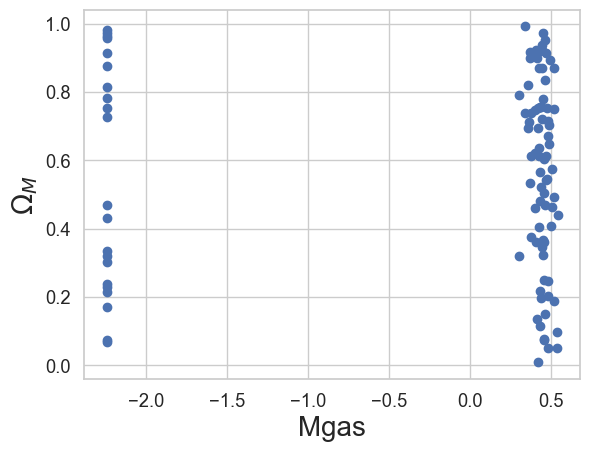

<Figure size 800x600 with 0 Axes>

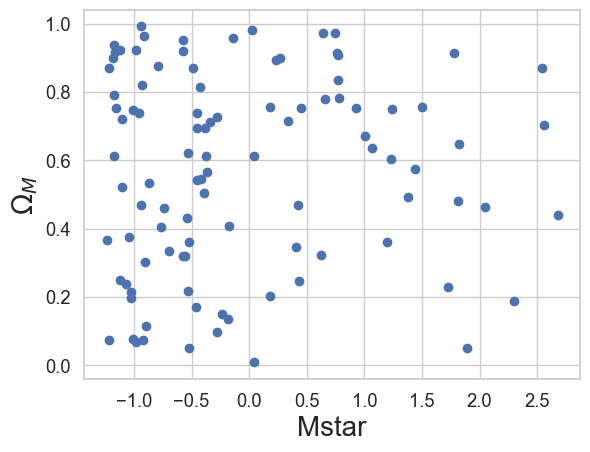

<Figure size 800x600 with 0 Axes>

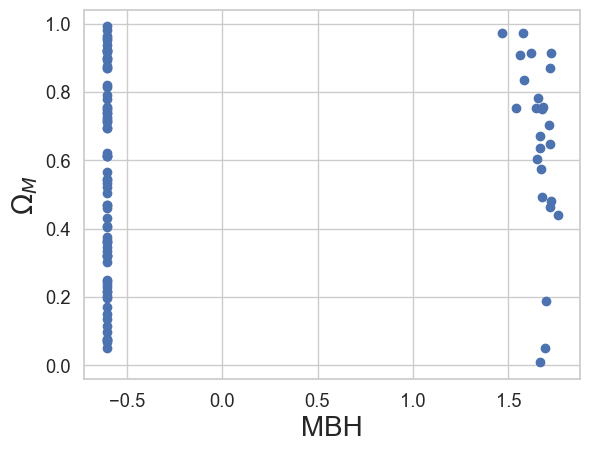

<Figure size 800x600 with 0 Axes>

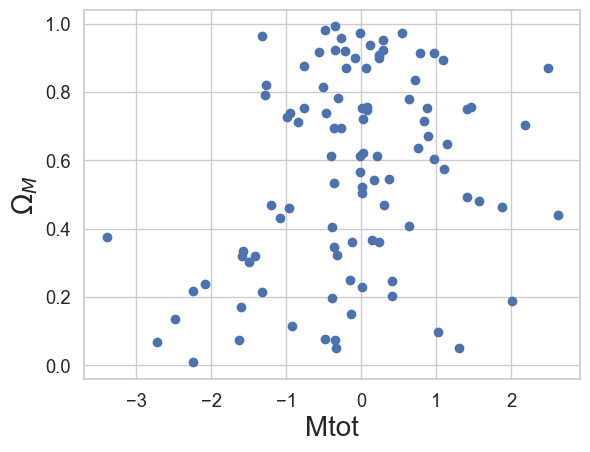

<Figure size 800x600 with 0 Axes>

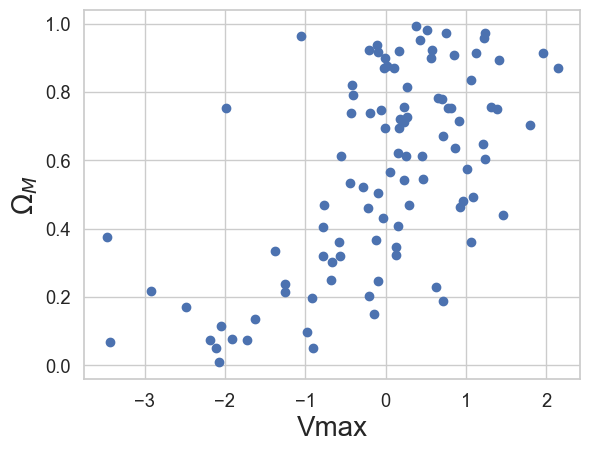

<Figure size 800x600 with 0 Axes>

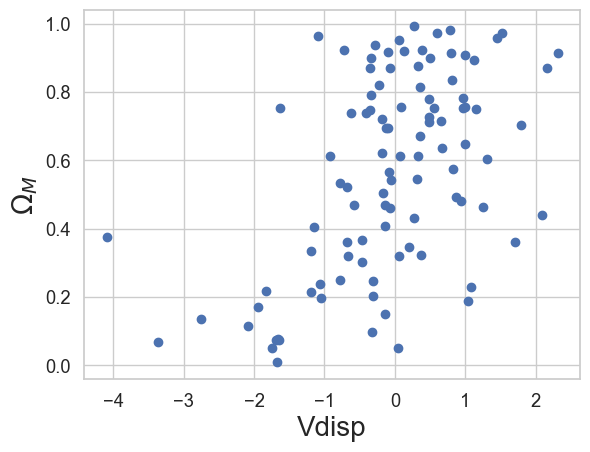

<Figure size 800x600 with 0 Axes>

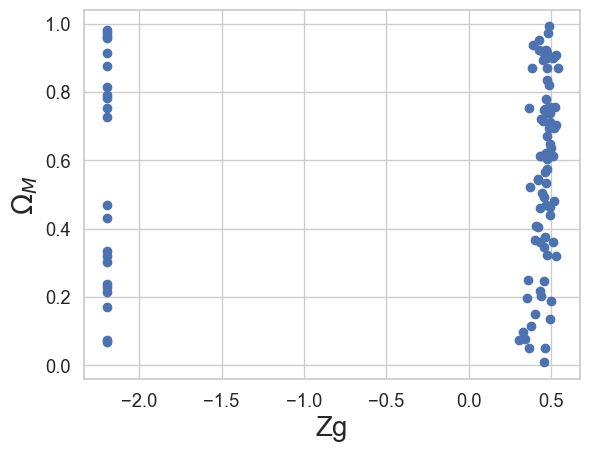

<Figure size 800x600 with 0 Axes>

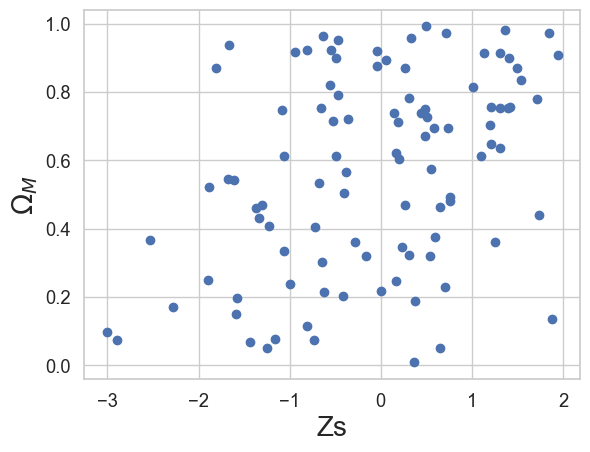

<Figure size 800x600 with 0 Axes>

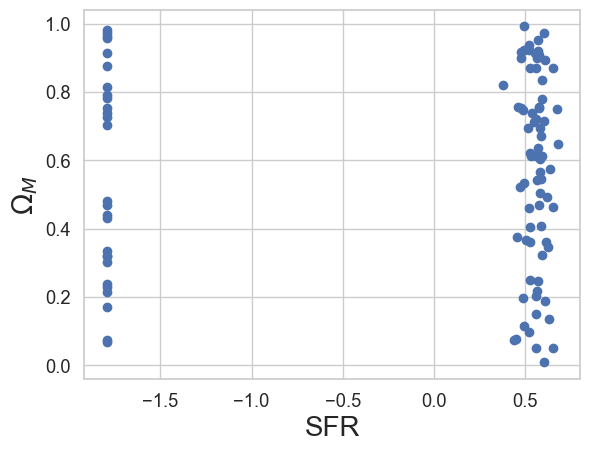

<Figure size 800x600 with 0 Axes>

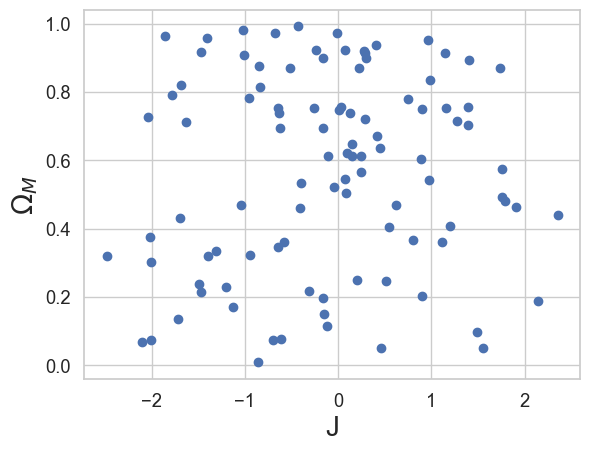

<Figure size 800x600 with 0 Axes>

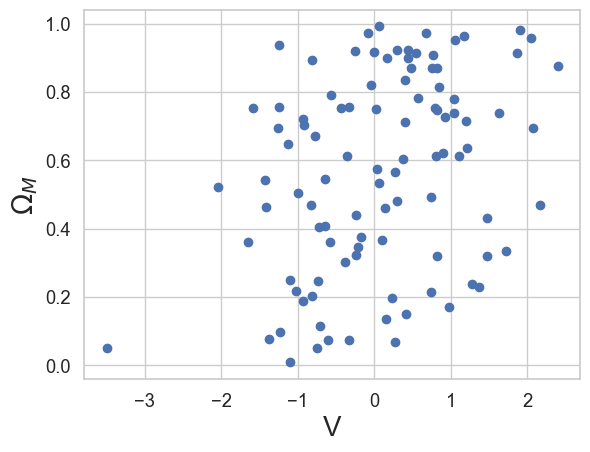

<Figure size 800x600 with 0 Axes>

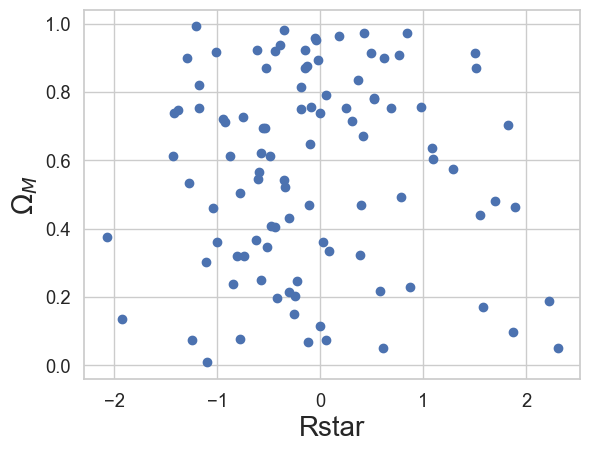

<Figure size 800x600 with 0 Axes>

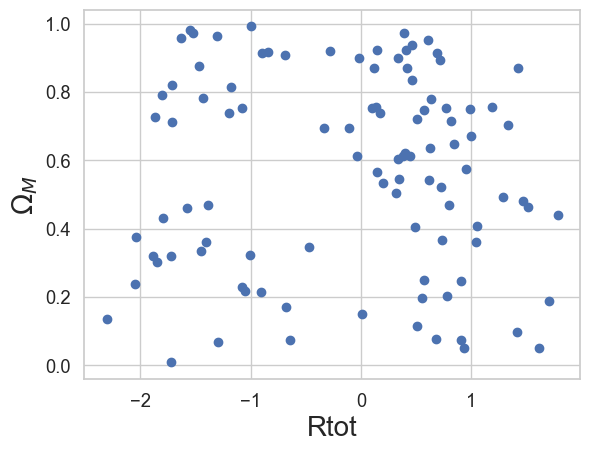

<Figure size 800x600 with 0 Axes>

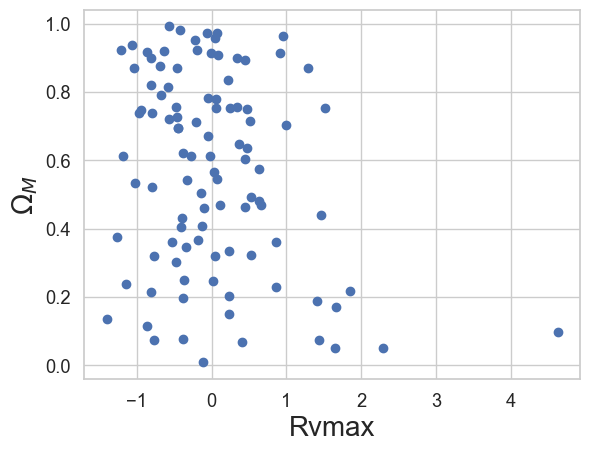

<Figure size 800x600 with 0 Axes>

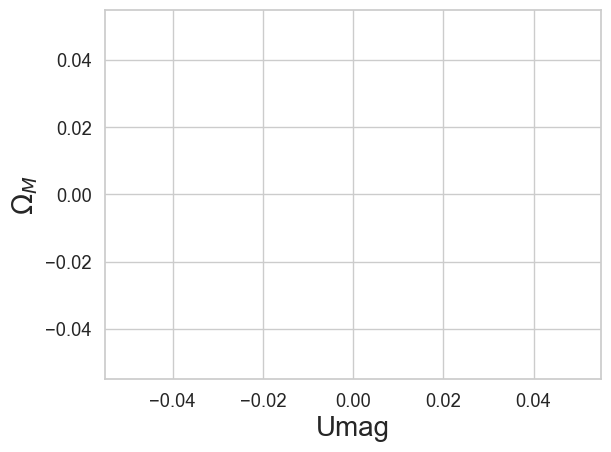

<Figure size 800x600 with 0 Axes>

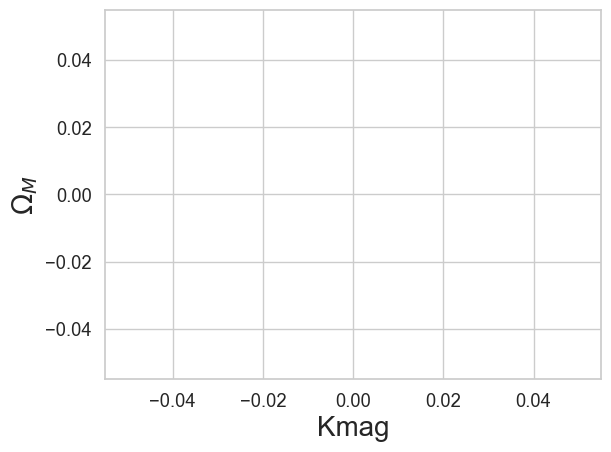

<Figure size 800x600 with 0 Axes>

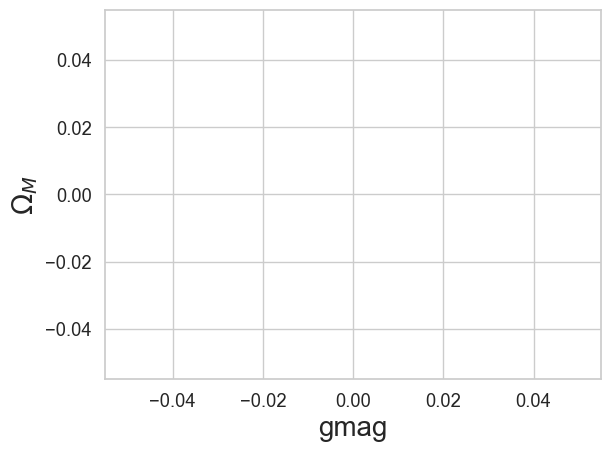

In [277]:
galprop = [
    "Mgas",
    "Mstar",
    "MBH",
    "Mtot",
    "Vmax",
    "Vdisp",
    "Zg",
    "Zs",
    "SFR",
    "J",
    "V",
    "Rstar",
    "Rtot",
    "Rvmax",
    "Umag",
    "Kmag",
    "gmag",
]
cosmo = [
    "$\Omega_M$",
    "$\sigma_8$",
    "$A_{SN1}$",
    "$A_{SN2}$",
    "$A_{AGN1}$",
    "$A_{AGN2}$",
]


# ,"Rstar","Rtot","Rvmax","Umag","Kmag","gmag"]

cosmo_ind = 0  # this contains omega matter


for galprop_ind, lbl in zip(range(len(galprop)), galprop):
    galpropvec = []

    cosmovec = []
    for example in dset_train.take(100):
        galpropvec.append(example["input"][galprop_ind].numpy())
        cosmovec.append(example["output"][cosmo_ind].numpy())
    # print(example['output'][0])
    # Create a line plot using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))
    plt.figure()
    plt.scatter(galpropvec, cosmovec)
    plt.xlabel(lbl, fontsize=20)
    plt.ylabel(cosmo[cosmo_ind], fontsize=20)

In [285]:
# [0,1,2,6,7,8,9,10,11,14,15,16]

version = "1.0.1"  # we change the version of the dataset
data_dir = (
    "/Users/marchuertascompany/Documents/python_scripts/camels/tensorflow_datasets"
)


def preprocessing(x, y, features):
    galprop = x
    cosmo = y[:, 0:1]
    return galprop, cosmo


def input_fn(
    mode="train", batch_size=64, features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
):
    """
    mode: 'train', test' or 'val'
    """
    keys = ["input", "output"]
    if mode == "train":
        dataset = tfds.load(
            "cosmo_1_galaxy:" + version, split="train", data_dir=data_dir
        )
        dataset = dataset.map(
            lambda x: (tf.gather(x["input"], features, axis=0), x["output"], features)
        )
        # filter_no_nan = lambda x,y: (tf.reduce_all(~tf.math.is_nan(x)))
        # dataset = dataset.filter(filter_no_nan)
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
        dataset = dataset.batch(batch_size, drop_remainder=True)
    if mode == "val":
        dataset = tfds.load(
            "cosmo_1_galaxy:" + version, split="train", data_dir=data_dir
        )
        dataset = dataset.map(
            lambda x: (tf.gather(x["input"], features, axis=0), x["output"], features)
        )
        dataset = dataset.batch(batch_size, drop_remainder=True)
    if mode == "test":
        dataset = tfds.load(
            "cosmo_1_galaxy:" + version, split="train", data_dir=data_dir
        )
        dataset = dataset.map(
            lambda x: (tf.gather(x["input"], features, axis=0), x["output"], features)
        )
        dataset = dataset.batch(batch_size, drop_remainder=False)

    dataset = dataset.map(preprocessing)  # Apply data preprocessing
    dataset = dataset.prefetch(
        -1
    )  # fetch next batches while training current one (-1 for autotune)
    return dataset

In [290]:
# Clear the cache for the dataset (replace 'cosmo_1_galaxy' with the actual dataset name)
# Clear the dataset cache for the specific version


cache_base_dir = "/Users/marchuertascompany/Documents/python_scripts/camels/cache"  # Replace with the desired base cache directory
version = "1.0.1"
cache_dir = os.path.join(cache_base_dir, "cosmo_1_galaxy", version)
tfds.core.download.download_manager._tfds_dir = cache_dir

dset_SIMBA = input_fn(mode="test")
omega_pred_mean = np.concatenate([mdn(batch[0]).mean() for batch in dset_SIMBA])
omega_pred_std = np.concatenate([mdn(batch[0]).stddev() for batch in dset_SIMBA])

print(omega_pred_mean)

omega_SIMBA = []
dset_test = tfds.load("cosmo_1_galaxy:" + version, split="train", data_dir=data_dir)
for example in dset_SIMBA.take(-1):
    omega_SIMBA.append(example["output"][0].numpy())


# Create a line plot using Seaborn
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(6, 6))
plt.errorbar(
    np.squeeze(omega_SIMBA[0:100]),
    np.squeeze(omega_pred_mean[0:100]),
    yerr=np.squeeze(omega_pred_std[0:100]),
    color="gray",
    fmt="none",
)
plt.scatter(omega_SIMBA[0:100], omega_pred_mean[0:100], color="red", s=15)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="red")
plt.xlabel("$\Omega_M$ True", fontsize=20)
plt.ylabel("$\Omega_M$ Pred", fontsize=20)

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="red", ls=":")

KeyboardInterrupt: 

# Part 4: Estimate $\sigma_8$ and $\Omega_{M}$ with a Multivariate Gaussian

We need to modify the function that creates the input data to include 

In [142]:
def preprocessing(x, y):
    galprop = x
    cosmo = y[:, 0:2]  # we now include omega_m and sigma_8 here
    return galprop, cosmo


def input_fn_omega_sigma8(mode="train", batch_size=64):
    """
    mode: 'train', test' or 'val'
    """
    keys = ["input", "output"]
    if mode == "train":
        dataset = tfds.load("cosmo_1_galaxy", split="train", data_dir=data_dir)
        dataset = dataset.map(lambda x: (x["input"], x["output"]))
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
        dataset = dataset.batch(batch_size, drop_remainder=True)
    if mode == "val":
        dataset = tfds.load("cosmo_1_galaxy", split="valid", data_dir=data_dir)
        dataset = dataset.map(lambda x: (x["input"], x["output"]))
        dataset = dataset.batch(batch_size, drop_remainder=True)
    if mode == "test":
        dataset = tfds.load("cosmo_1_galaxy", split="test", data_dir=data_dir)
        dataset = dataset.map(lambda x: (x["input"], x["output"]))
        dataset = dataset.batch(batch_size, drop_remainder=False)

    dataset = dataset.map(preprocessing)  # Apply data preprocessing
    dataset = dataset.prefetch(
        -1
    )  # fetch next batches while training current one (-1 for autotune)
    return dataset

In [143]:
tfd = tfp.distributions
tfb = tfp.bijectors
tfkl = tf.keras.layers

num_components = 1
event_shape = 2

params_size = tfp.layers.MultivariateNormalTriL.params_size(event_shape)

mdn_multivariate = tf.keras.Sequential(
    [
        tfkl.Input(shape=(12)),
        tfkl.Dense(1022, activation="LeakyReLU"),
        tfkl.Dropout(0.5277883627689858),
        tfkl.Dense(975, activation="LeakyReLU"),
        tfkl.Dropout(0.20184706977545483),
        tfkl.Dense(1311, activation="LeakyReLU"),
        tfkl.Dropout(0.5022290156424203),
        tfkl.Dense(units=params_size, activation=None),
        tfp.layers.MultivariateNormalTriL(event_shape),
    ]
)

negloglik = lambda y, p_y: -p_y.log_prob(y)


opt = tf.keras.optimizers.Adam(learning_rate=0.0002)
mdn_multivariate.compile(loss=negloglik, optimizer=opt)

In [144]:
dset_train = input_fn_omega_sigma8()
dset_val = input_fn_omega_sigma8(mode="val")
history = mdn_multivariate.fit(
    dset_train, validation_data=dset_val, epochs=20, steps_per_epoch=3000
)

Epoch 1/20
3000/3000 [==============================] - 5s 2ms/step - loss: 0.4638 - val_loss: 0.0668
Epoch 2/20
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0976 - val_loss: -0.0306
Epoch 3/20
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0396 - val_loss: -0.0596
Epoch 4/20
3000/3000 [==============================] - 3s 922us/step - loss: 0.0130 - val_loss: -0.1000
Epoch 5/20
3000/3000 [==============================] - 3s 865us/step - loss: -0.0076 - val_loss: -0.1143
Epoch 6/20
3000/3000 [==============================] - 3s 860us/step - loss: -0.0274 - val_loss: -0.1354
Epoch 7/20
3000/3000 [==============================] - 3s 859us/step - loss: -0.0351 - val_loss: -0.1458
Epoch 8/20
3000/3000 [==============================] - 3s 874us/step - loss: -0.0459 - val_loss: -0.1739
Epoch 9/20
3000/3000 [==============================] - 3s 863us/step - loss: -0.0595 - val_loss: -0.1655
Epoch 10/20
3000/3000 [==============================] - 

Plot the results

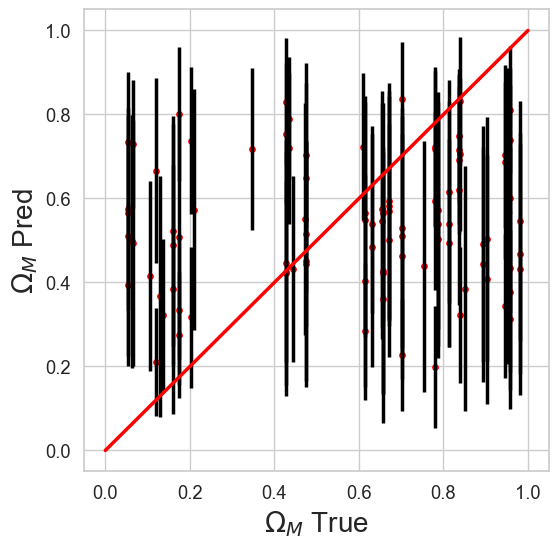

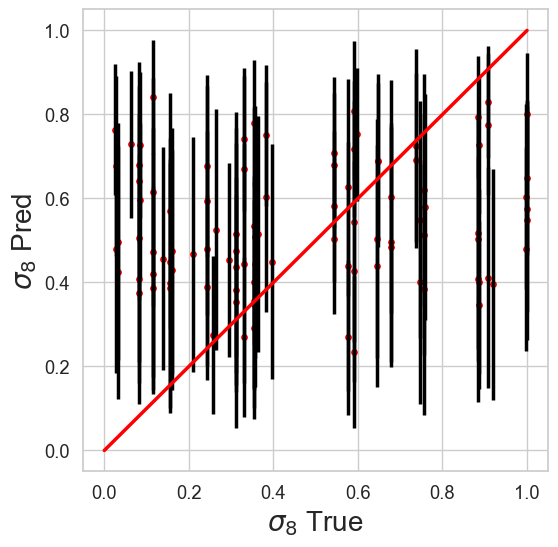

In [146]:
dset_test = input_fn_omega_sigma8(mode="test")
omega_pred_mean = np.concatenate(
    [mdn_multivariate(batch[0]).mean()[0] for batch in dset_test]
)
omega_pred_std = np.concatenate(
    [mdn_multivariate(batch[0]).stddev()[0] for batch in dset_test]
)

sigma8_pred_mean = np.concatenate(
    [mdn_multivariate(batch[0]).mean()[1] for batch in dset_test]
)
sigma8_pred_std = np.concatenate(
    [mdn_multivariate(batch[0]).stddev()[1] for batch in dset_test]
)


omega_test = []
sigma8_test = []
dset_test = tfds.load("cosmo_1_galaxy", split="test", data_dir=data_dir)
for example in dset_test.take(-1):
    omega_test.append(example["output"][0].numpy())
    sigma8_test.append(example["output"][1].numpy())


sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(6, 6))
plt.errorbar(
    np.squeeze(omega_test[0:100]),
    np.squeeze(omega_pred_mean[0:100]),
    yerr=np.squeeze(omega_pred_std[0:100]),
    color="black",
    fmt="none",
)
plt.scatter(omega_test[0:100], omega_pred_mean[0:100], color="red", s=15)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="red")
plt.xlabel("$\Omega_M$ True", fontsize=20)
plt.ylabel("$\Omega_M$ Pred", fontsize=20)
plt.show()

sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(6, 6))
plt.errorbar(
    np.squeeze(sigma8_test[0:100]),
    np.squeeze(sigma8_pred_mean[0:100]),
    yerr=np.squeeze(sigma8_pred_std[0:100]),
    color="black",
    fmt="none",
)
plt.scatter(sigma8_test[0:100], sigma8_pred_mean[0:100], color="red", s=15)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color="red")
plt.xlabel("$\sigma_8$ True", fontsize=20)
plt.ylabel("$\sigma_8$ Pred", fontsize=20)
plt.show()

Plot some posterior distributions

2023-08-20 16:49:42.604946: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<Figure size 800x600 with 0 Axes>

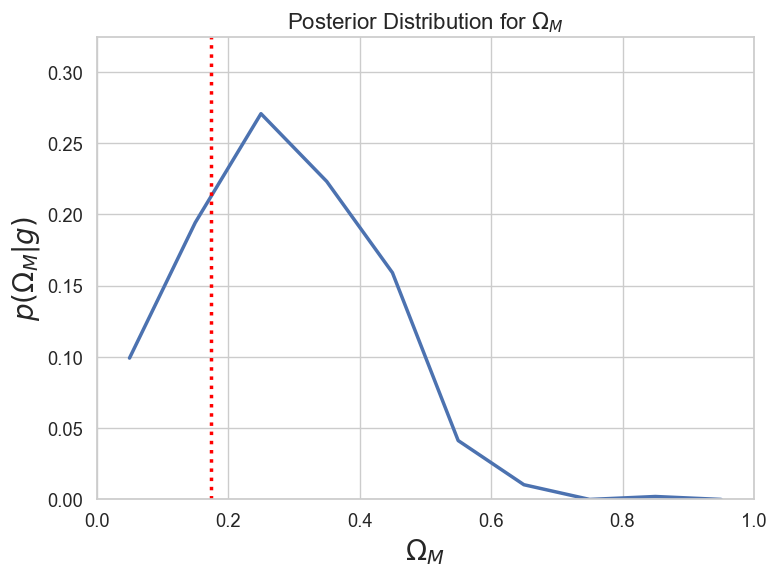

<Figure size 800x600 with 0 Axes>

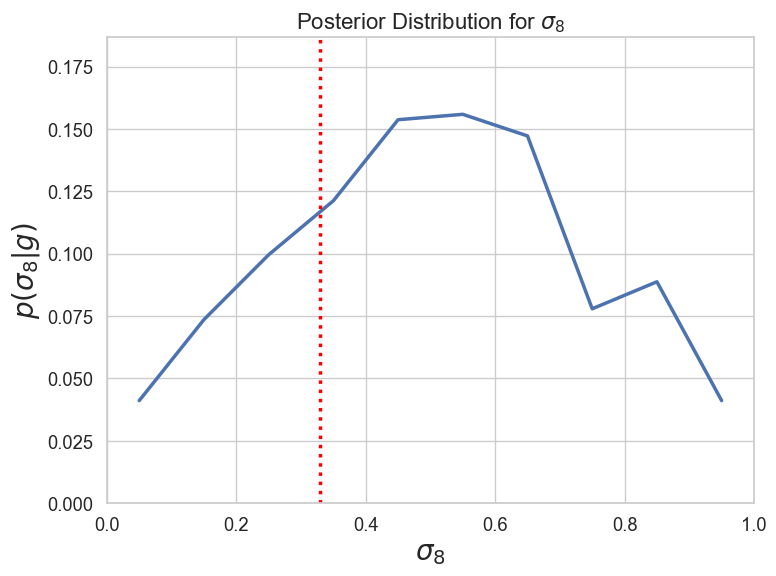

<Figure size 800x600 with 0 Axes>

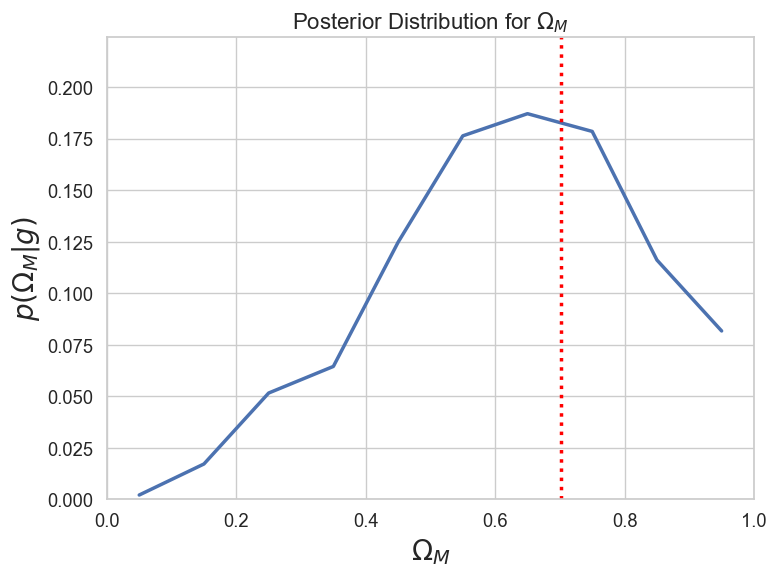

<Figure size 800x600 with 0 Axes>

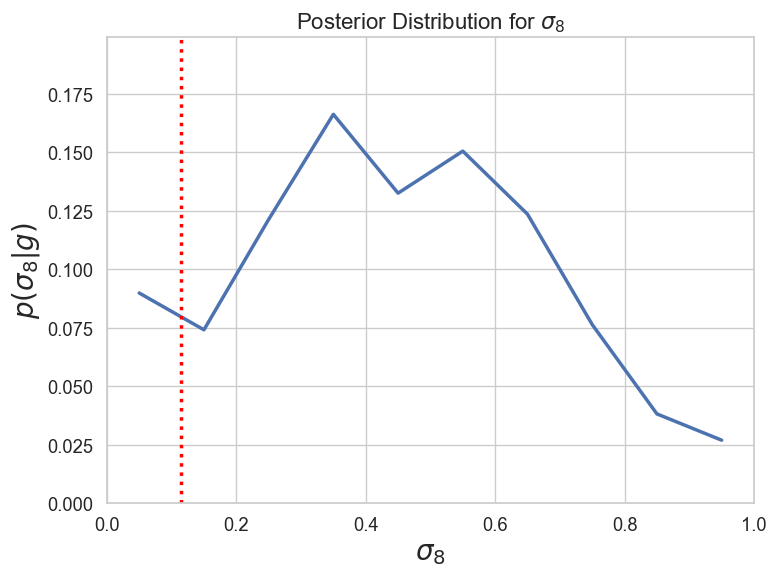

<Figure size 800x600 with 0 Axes>

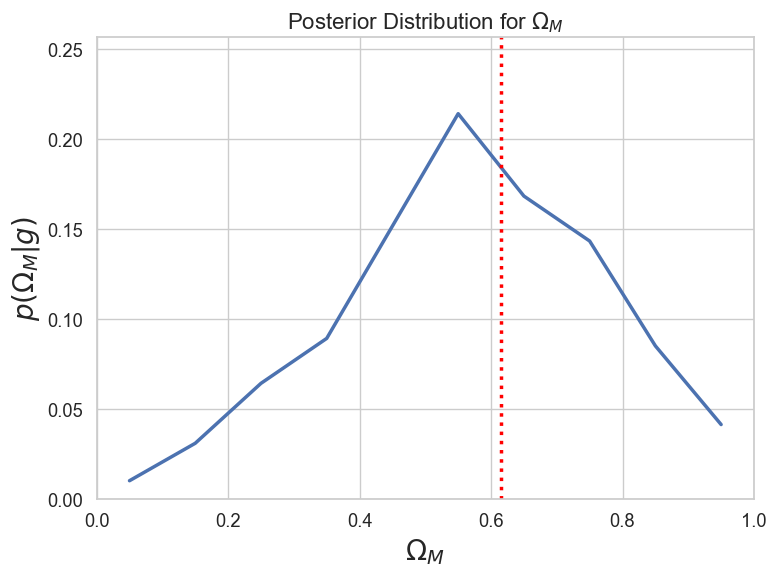

<Figure size 800x600 with 0 Axes>

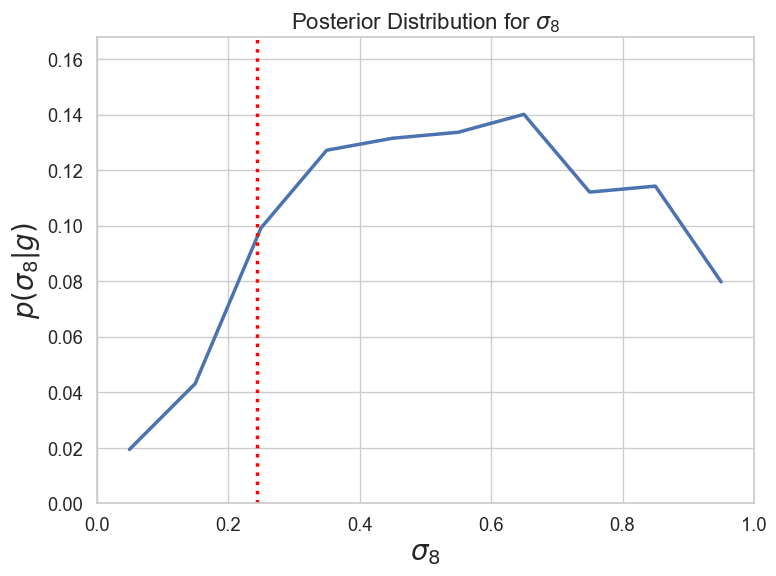

<Figure size 800x600 with 0 Axes>

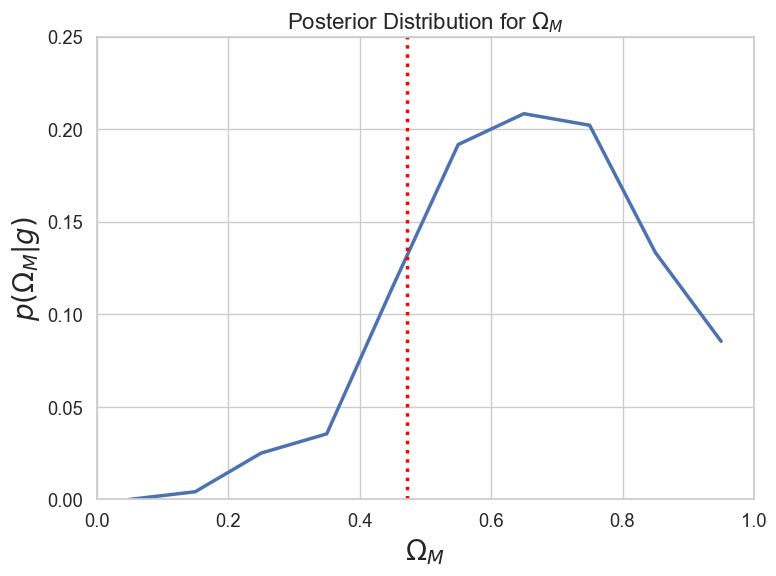

<Figure size 800x600 with 0 Axes>

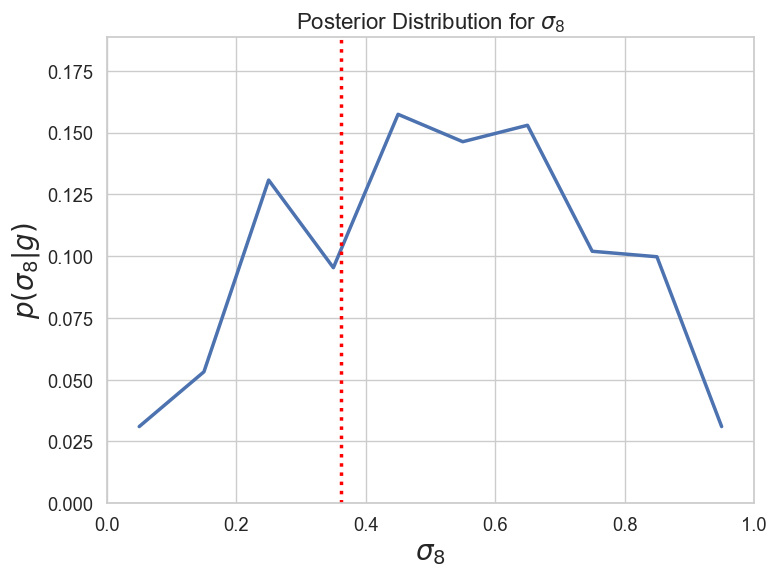

<Figure size 800x600 with 0 Axes>

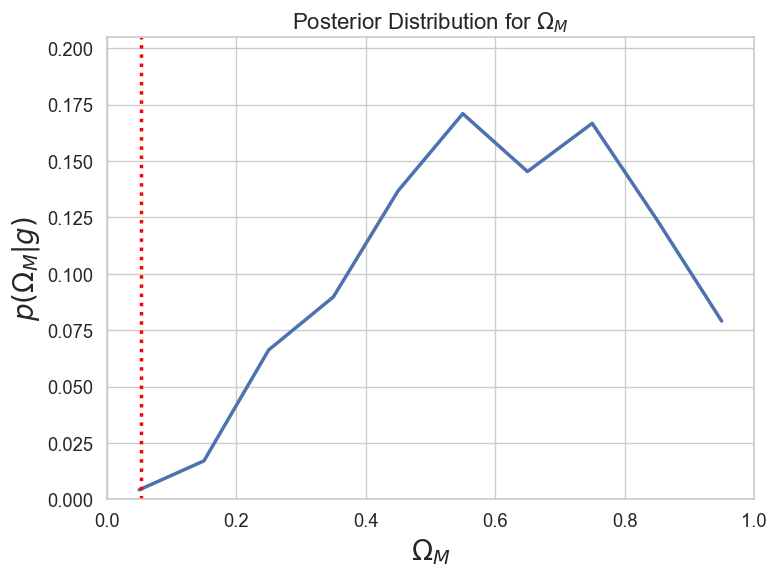

<Figure size 800x600 with 0 Axes>

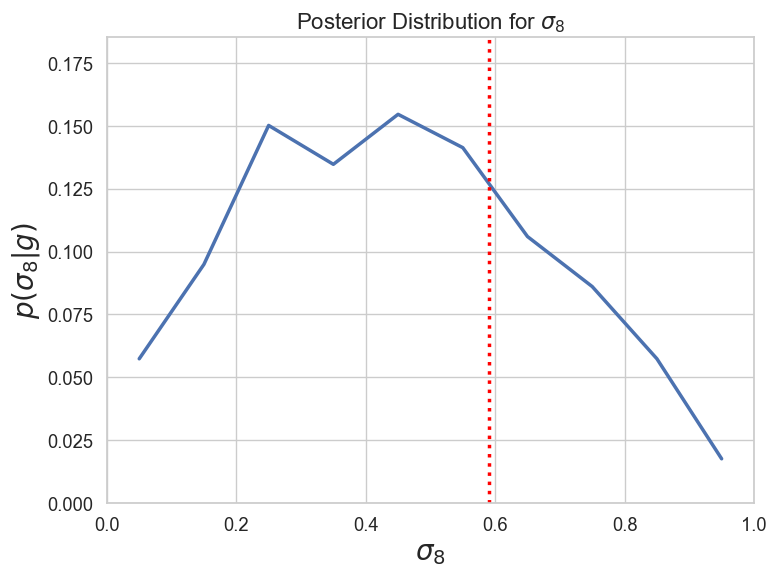

In [147]:
import seaborn as sns

dset_test = input_fn_omega_sigma8(mode="test")
iterator = iter(dset_test)

nexamples = 1
for b in range(nexamples):
    batch = iterator.get_next()
    nsamples = 500
    omega_pred_samples = []
    sigma8_pred_samples = []
    for i in range(nsamples):
        omega_pred_samples.append((mdn_multivariate(batch[0]).sample())[b, 0])
        sigma8_pred_samples.append((mdn_multivariate(batch[0]).sample())[b, 1])

    # Create a normalized histogram using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))

    # Compute the PDF using a normalized histogram
    hist, bin_edges = np.histogram(
        np.squeeze(np.array(omega_pred_samples)), bins=10, density=True, range=(0, 1)
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    pdf = hist * np.diff(bin_edges)

    # Create a line plot using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))

    # Plot the PDF as a line plot
    sns.lineplot(x=bin_centers, y=pdf, color="b")
    plt.xlabel(r"$\Omega_M$", fontsize=20)
    plt.ylabel(r"$p(\Omega_M|g)$", fontsize=20)
    plt.title("Posterior Distribution for $\Omega_M$", fontsize=16)
    plt.xlim(0, 1)
    plt.ylim(0, max(pdf) * 1.2)  # Adjust y-axis limits as needed

    plt.axvline(x=batch[1][b, 0], color="red", ls=":")

    # Save or show the plot
    plt.tight_layout()
    plt.savefig("omega_pdf_plot.png")  # Save the plot to a file
    plt.show()  # Display the plot

    # Create a normalized histogram using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))

    # Compute the PDF using a normalized histogram
    hist, bin_edges = np.histogram(
        np.squeeze(np.array(sigma8_pred_samples)), bins=10, density=True, range=(0, 1)
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    pdf = hist * np.diff(bin_edges)

    # Create a line plot using Seaborn
    sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
    plt.figure(figsize=(8, 6))

    # Plot the PDF as a line plot
    sns.lineplot(x=bin_centers, y=pdf, color="b")
    plt.xlabel(r"$\sigma_8$", fontsize=20)
    plt.ylabel(r"$p(\sigma_8|g)$", fontsize=20)
    plt.title("Posterior Distribution for $\sigma_8$", fontsize=16)
    plt.xlim(0, 1)
    plt.ylim(0, max(pdf) * 1.2)  # Adjust y-axis limits as needed

    # print(batch)
    plt.axvline(x=batch[1][b, 1], color="red", ls=":")

    # Save or show the plot
    plt.tight_layout()
    plt.savefig("sigma8_pdf_plot.png")  # Save the plot to a file
    plt.show()

Make a corner plot

2023-08-20 16:54:16.481953: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


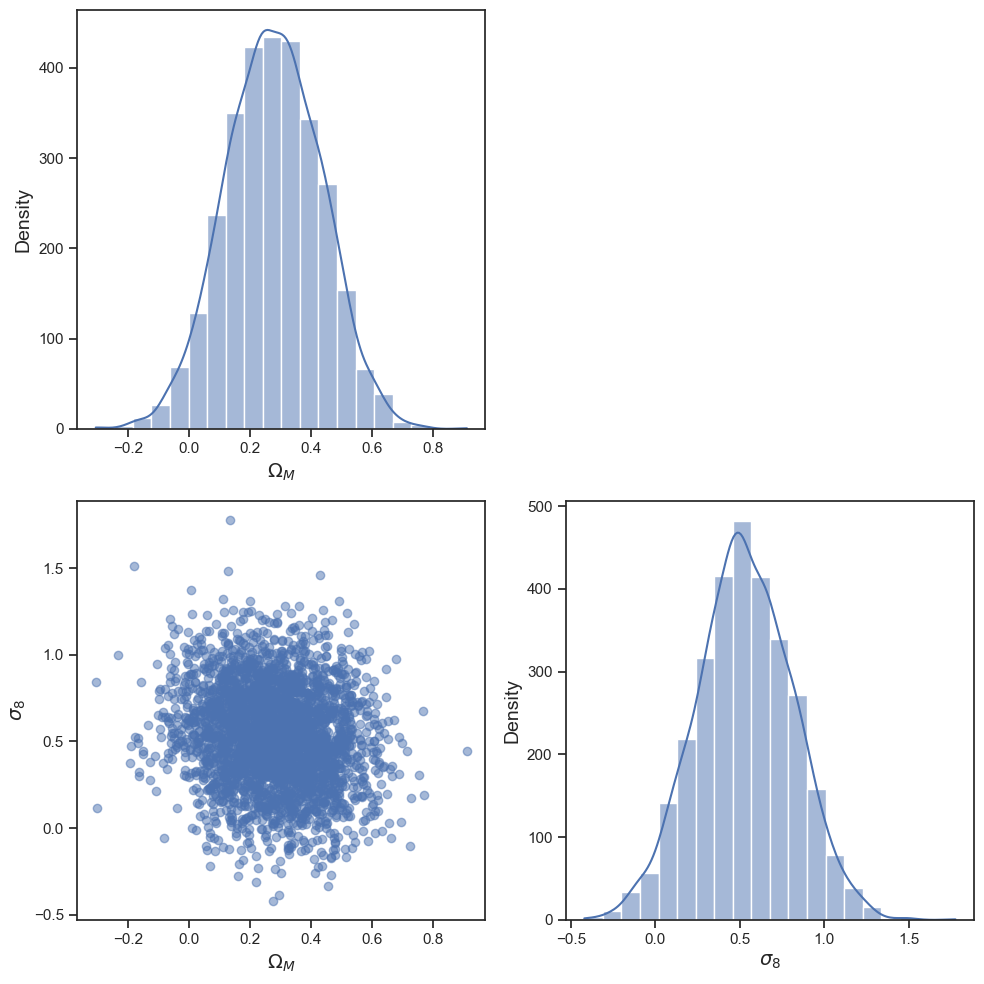

In [148]:
# Create the test dataset
dset_test = input_fn_omega_sigma8(mode="test")
iterator = iter(dset_test)
batch = iterator.get_next()

nsamples = 3000
nplots = 1
# Generate samples from the model
for b in range(nplots):
    # Lists to store samples
    omega_pred_samples = []
    sigma8_pred_samples = []
    for i in range(nsamples):
        samples = mdn_multivariate(batch[0]).sample()[b]
        omega_pred_samples.append(samples[0])
        sigma8_pred_samples.append(samples[1])

    # Combine the samples into a matrix
    samples_matrix = np.vstack((omega_pred_samples, sigma8_pred_samples)).T

    # Create a corner plot
    sns.set(style="ticks")
    corner_labels = [r"$\Omega_M$", r"$\sigma_8$"]
    plt.figure(figsize=(10, 10))

    # Create scatter plots for the lower diagonal
    for i in range(2):
        for j in range(i + 1):
            plt.subplot(2, 2, i * 2 + j + 1)
            if i == j:
                sns.histplot(samples_matrix[:, i], bins=20, kde=True, color="b")
                plt.xlabel(corner_labels[i], fontsize=14)
                plt.ylabel("Density", fontsize=14)
            else:
                plt.scatter(
                    samples_matrix[:, j], samples_matrix[:, i], color="b", alpha=0.5
                )
                plt.xlabel(corner_labels[j], fontsize=14)
                plt.ylabel(corner_labels[i], fontsize=14)

    plt.tight_layout()
    plt.show()